### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [76]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 21.5 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
import sqlite3
from sqlite3 import Error

def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()
            
create_sqlit_connection("/home/Assignment/02_training_pipeline/notebooks/", "lead_scoring_model_experimentation.db")

2.6.0


In [7]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [9]:
# setup pycaret 
mlflow.set_experiment('Lead_scoring_mlflow_experimentation')


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='Lead_scoring_mlflow_experimentation', tags={}>

In [10]:
dataset['city_tier'] = dataset.city_tier.astype('category')

In [11]:
ONE_HOT_ENCODED_FEATURES = ['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0', 'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3', 'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0', 'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15', 'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26', 'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4', 'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8', 'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14', 'first_utm_source_c_Level16', 'first_utm_source_c_Level2',
       'first_utm_source_c_Level4', 'first_utm_source_c_Level5', 'first_utm_source_c_Level6', 'first_utm_source_c_Level7',
       'first_utm_source_c_others', 'total_leads_droppped', 'referred_lead', 
       'assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction',
       'syllabus_interaction', 'app_complete_flag']

In [12]:
FEATURES_TO_ENCODE = ['city_tier', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']

In [13]:
encoded_df = pd.DataFrame(columns= ONE_HOT_ENCODED_FEATURES) # from constants.py
placeholder_df = pd.DataFrame()

In [14]:
# One-Hot Encoding using get_dummies for the specified categorical features
for f in FEATURES_TO_ENCODE:
    if(f in dataset.columns):
        encoded = pd.get_dummies(dataset[f])
        encoded = encoded.add_prefix(f + '_')
        placeholder_df = pd.concat([placeholder_df, encoded], axis=1)
    else:
        print('Feature not found')

In [15]:
placeholder_df.columns

Index(['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0',
       'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3',
       'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0',
       'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15',
       'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26',
       'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4',
       'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8',
       'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14',
       'first_utm_source_c_Level16'

In [16]:
# Implement these steps to prevent dimension mismatch during inference
for feature in encoded_df.columns:
    if feature in dataset.columns:
        encoded_df[feature] = dataset[feature]
    if feature in placeholder_df.columns:
        encoded_df[feature] = placeholder_df[feature]
# fill all null values
encoded_df.fillna(0, inplace=True)

In [17]:
encoded_df.head()

,city_tier_1.0,city_tier_2.0,city_tier_3.0,first_platform_c_Level0,first_platform_c_Level1,first_platform_c_Level2,first_platform_c_Level3,first_platform_c_Level7,first_platform_c_Level8,first_platform_c_others,first_utm_medium_c_Level0,first_utm_medium_c_Level10,first_utm_medium_c_Level11,first_utm_medium_c_Level13,first_utm_medium_c_Level15,first_utm_medium_c_Level16,first_utm_medium_c_Level2,first_utm_medium_c_Level20,first_utm_medium_c_Level26,first_utm_medium_c_Level3,first_utm_medium_c_Level30,first_utm_medium_c_Level33,first_utm_medium_c_Level4,first_utm_medium_c_Level43,first_utm_medium_c_Level5,first_utm_medium_c_Level6,first_utm_medium_c_Level8,first_utm_medium_c_Level9,first_utm_medium_c_others,first_utm_source_c_Level0,first_utm_source_c_Level14,first_utm_source_c_Level16,first_utm_source_c_Level2,first_utm_source_c_Level4,first_utm_source_c_Level5,first_utm_source_c_Level6,first_utm_source_c_Level7,first_utm_source_c_others,total_leads_droppped,referred_lead,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction,app_complete_flag
0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
target_df = dataset[['app_complete_flag']]

In [19]:
dataset.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [20]:
# setup pycaret 
Baseline_model_exp01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [21]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7387,0.8210,0.8306,0.7033,0.7617,0.4768,0.4849,9.1340
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8326,0.7025,0.7620,0.4764,0.4850,1.4980
rf,Random Forest Classifier,0.7373,0.8185,0.8227,0.7044,0.7590,0.4740,0.4809,2.9540
et,Extra Trees Classifier,0.7367,0.8174,0.8209,0.7043,0.7582,0.4728,0.4795,3.7440
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4722,0.4789,0.2240
lr,Logistic Regression,0.7099,0.7844,0.8222,0.6732,0.7403,0.4191,0.4299,2.3600
ridge,Ridge Classifier,0.6998,0.0000,0.7969,0.6692,0.7275,0.3990,0.4065,0.0900
lda,Linear Discriminant Analysis,0.6998,0.7739,0.7969,0.6692,0.7275,0.3990,0.4065,0.4740
nb,Naive Bayes,0.6624,0.7337,0.8926,0.6129,0.7266,0.3230,0.3643,0.4840


In [22]:
# create a model which gives the highest accuracy
lightgbm  = create_model('lightgbm', fold = 5)

In [23]:
print(lightgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


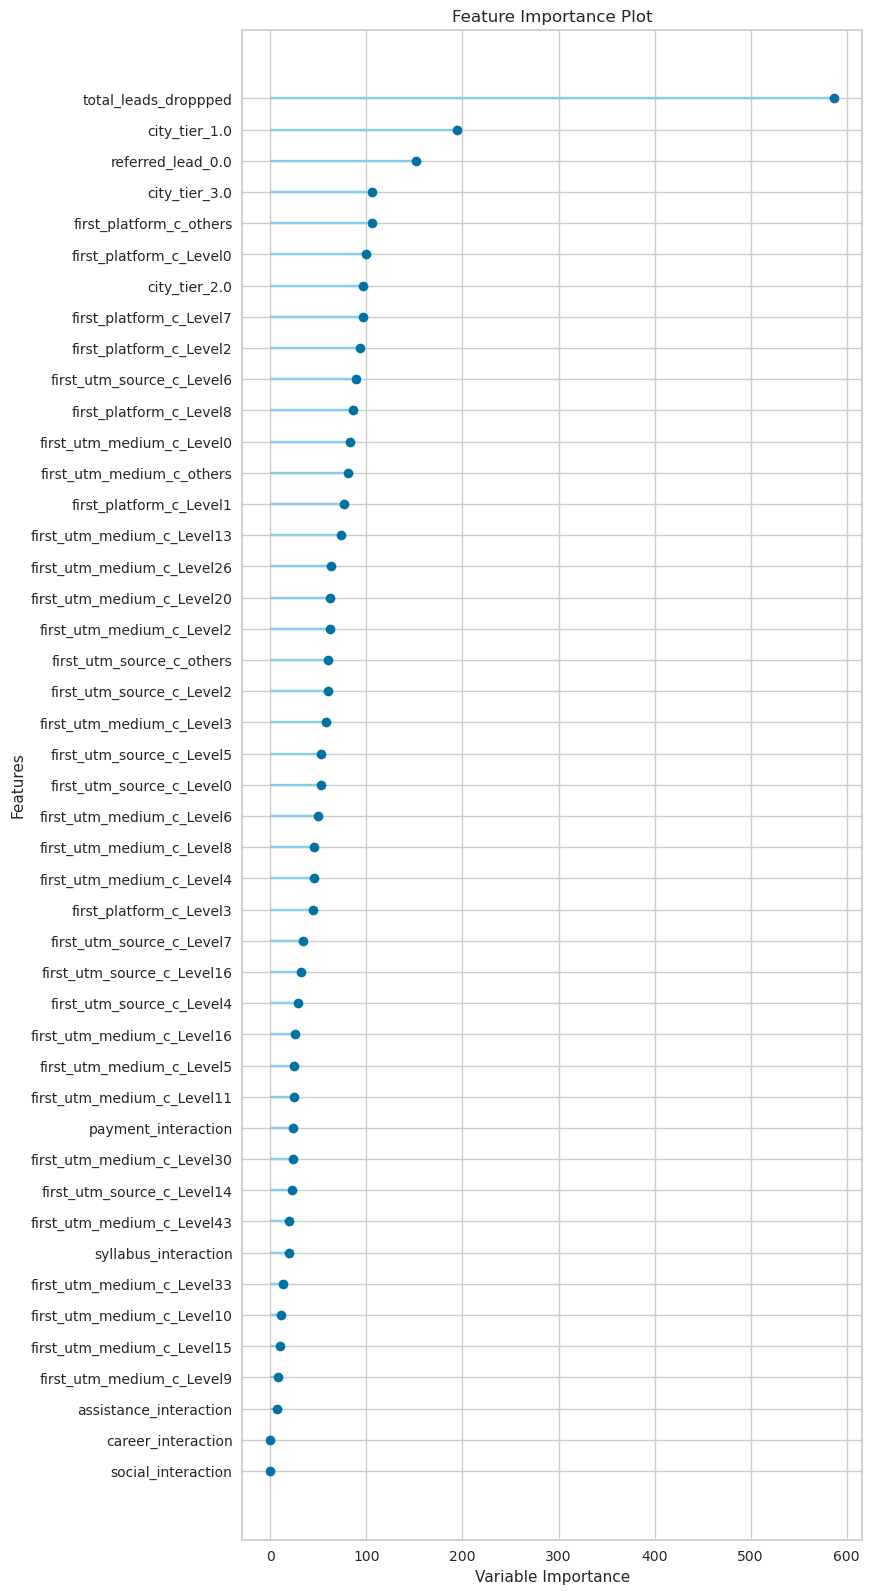

In [24]:
# create feature importance plot
plot_model(lightgbm, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [29]:
encoded_df.columns

Index(['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0',
       'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3',
       'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0',
       'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15',
       'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26',
       'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4',
       'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8',
       'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14',
       'first_utm_source_c_Level16'

In [32]:
encoded_df_sig_features = encoded_df.drop(['assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction', 'syllabus_interaction'],axis=1, inplace=True)

In [39]:
encoded_df_sig_features = encoded_df

In [40]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

Baseline_model_exp02 = setup(data = encoded_df_sig_features, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False, normalize=False,
                   transformation=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 41)"
5,Missing Values,False
6,Numeric Features,39
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [41]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7385,0.8209,0.8310,0.7030,0.7617,0.4764,0.4846,8.3700
lightgbm,Light Gradient Boosting Machine,0.7384,0.8211,0.8324,0.7024,0.7619,0.4763,0.4848,1.3080
rf,Random Forest Classifier,0.7373,0.8184,0.8231,0.7043,0.7591,0.4741,0.4811,2.7640
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7581,0.4727,0.4794,3.4560
dt,Decision Tree Classifier,0.7363,0.8165,0.8204,0.7041,0.7578,0.4721,0.4788,0.1840
lr,Logistic Regression,0.7099,0.7842,0.8223,0.6732,0.7403,0.4191,0.4299,1.2640
ridge,Ridge Classifier,0.6995,0.0000,0.7961,0.6691,0.7271,0.3983,0.4058,0.0820
lda,Linear Discriminant Analysis,0.6995,0.7733,0.7961,0.6691,0.7271,0.3984,0.4059,0.5300
nb,Naive Bayes,0.6724,0.7338,0.8568,0.6277,0.7246,0.3435,0.3694,0.4880


In [42]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lightgbm  = create_model('lightgbm', fold = 5)

In [43]:
print(lightgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [44]:
!pip install optuna

  Using cached optuna-3.1.0-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV # run pip install scikit-optimize
import mlflow
import mlflow.sklearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, roc_auc_score
from datetime import datetime
from datetime import date
import time

In [67]:
X = encoded_df_sig_features.drop(['app_complete_flag'], axis=1)
y = encoded_df_sig_features[['app_complete_flag']]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

model_config = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split' ,
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': 42,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': 'warn',
    'subsample': 1.0,
    'subsample_for_bin': 200000 ,
    'subsample_freq': 0
}

#Model Training
with mlflow.start_run(run_name='run_LightGB_withoutHPTune', nested=True) as run:
    #Model Training
    clf = lgb.LGBMClassifier()
    clf.set_params(**model_config) 
    clf.fit(X_train, y_train)

    mlflow.sklearn.log_model(sk_model=clf,artifact_path="models", registered_model_name='LightGBM')
    mlflow.log_params(model_config)    

    # predict the results on training dataset
    y_pred=clf.predict(X_test)

    #Log metrics
    acc=accuracy_score(y_pred, y_test)
    conf_mat = confusion_matrix(y_pred, y_test)
    precision = precision_score(y_pred, y_test,average= 'macro')
    recall = recall_score(y_pred, y_test, average= 'macro')
    f1 = f1_score(y_pred, y_test, average='macro')
    roc_auc = roc_auc_score(y_pred, y_test)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    class_zero = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)
    class_one = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    print('acc: ' + str(acc) + ', precision: ' + str(precision) + ', recall: ' + str(recall) + ', f1: ' + str(f1) + ', roc_auc: ' + str(roc_auc))

    mlflow.log_metric('test_accuracy', acc)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("Precision_0", class_zero[0])
    mlflow.log_metric("Precision_1", class_one[0])
    mlflow.log_metric("Recall_0", class_zero[1])
    mlflow.log_metric("Recall_1", class_one[1])
    mlflow.log_metric("f1_0", class_zero[2])
    mlflow.log_metric("f1_1", class_one[2])
    mlflow.log_metric("False Negative", fn)
    mlflow.log_metric("True Negative", tn)
    # mlflow.log_metric("f1", f1_score)

    runID = run.info.run_uuid
    print("Inside MLflow Run with id {}".format(runID))

Successfully registered model 'LightGBM'.
2023/01/22 18:59:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM, version 1
Created version '1' of model 'LightGBM'.


acc: 0.7397526834473668, precision: 0.7388142607643076, recall: 0.7484068710342674, f1: 0.7369479772443696, roc_auc: 0.7484068710342674
Inside MLflow Run with id 60bbaf5dbe104801bb889bd5882ae7f4


In [69]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [70]:
#hyper parameter tuning

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

categoricals = []
indexes_of_categories = [X_train.columns.get_loc(col) for col in categoricals]
    
gkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(X, y) # startifyKFold 

gridParams = {
    'learning_rate': [0.01,0.1],
    'n_estimators': [50,100,200],
    'num_leaves': [16,31,35], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [42, 500],
    'colsample_bytree' : [0.66, 1.0],
    'subsample' : [0.7,0.75,1.0],
    'reg_alpha' : [0.0,1.0],
    'reg_lambda' : [0.0,1,1.2,1.4],
    'max_depth': [3,5]
    }

model_params = {
    'objective':'binary', 
    'num_boost_round':200, 
    'metric':'roc_auc',
    'categorical_feature':indexes_of_categories,
    'verbose':-1,
    'force_row_wise':True
               }

lgb_estimator = lgb.LGBMClassifier()
lgb_estimator.set_params(**model_params)

gsearch = BayesSearchCV(estimator=lgb_estimator, search_spaces=gridParams, cv=gkf,n_iter=32,random_state=0,n_jobs=-1,verbose=-1,scoring='roc_auc')
lgb_model = gsearch.fit(X, y)
best_model = lgb_model.best_estimator_
auc_score = lgb_model.best_score_

timestamp = str(int(time.time()))
with mlflow.start_run(run_name=f"LGBM_Bayes_Search_{timestamp}", nested=True) as run:
    y_pred = best_model.predict(X_test)
    
    mlflow.sklearn.log_model(best_model,registered_model_name='LightGBM',artifact_path='models')
    
    model_params = best_model.get_params()
    [mlflow.log_param(p, model_params[p]) for p in gridParams]

    #Log metrics
    acc=accuracy_score(y_pred, y_test)
    conf_mat = confusion_matrix(y_pred, y_test)
    precision = precision_score(y_pred, y_test,average= 'macro')
    recall = recall_score(y_pred, y_test, average= 'macro')
    f1 = f1_score(y_pred, y_test, average='macro')
    roc_auc = roc_auc_score(y_pred, y_test)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    class_zero = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)
    class_one = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
 
    mlflow.log_metric('test_accuracy', acc)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("Precision_0", class_zero[0])
    mlflow.log_metric("Precision_1", class_one[0])
    mlflow.log_metric("Recall_0", class_zero[1])
    mlflow.log_metric("Recall_1", class_one[1])
    mlflow.log_metric("f1_0", class_zero[2])
    mlflow.log_metric("f1_1", class_one[2])
    mlflow.log_metric("False Negative", fn)
    mlflow.log_metric("True Negative", tn)

    runID = run.info.run_uuid
    print("Inside MLflow Run with id {}".format(runID))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/01/22 19:05:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM, version 2
Created version '2' of model 'LightGBM'.


Inside MLflow Run with id 7a8b59196b184f53931d9a20ee5d76e0


In [71]:
timestamp = str(int(time.time()))
with mlflow.start_run(run_name=f"LGBM_Bayes_Search_{timestamp}", nested=True) as run:
    y_pred = best_model.predict(X_test)
    
    mlflow.sklearn.log_model(best_model,registered_model_name='LightGBM',artifact_path='models')
    
    model_params = best_model.get_params()
    [mlflow.log_param(p, model_params[p]) for p in gridParams]

    #Log metrics
    acc=accuracy_score(y_pred, y_test)
    conf_mat = confusion_matrix(y_pred, y_test)
    precision = precision_score(y_pred, y_test,average= 'macro')
    recall = recall_score(y_pred, y_test, average= 'macro')
    f1 = f1_score(y_pred, y_test, average='macro')
    roc_auc = roc_auc_score(y_pred, y_test)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    class_zero = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)
    class_one = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    print('acc: ' + str(acc) + ', precision: ' + str(precision) + ', recall: ' + str(recall) + ', f1: ' + str(f1) + ', roc_auc: ' + str(roc_auc) + ", f1: " + str(f1))

 
    mlflow.log_metric('test_accuracy', acc)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("Precision_0", class_zero[0])
    mlflow.log_metric("Precision_1", class_one[0])
    mlflow.log_metric("Recall_0", class_zero[1])
    mlflow.log_metric("Recall_1", class_one[1])
    mlflow.log_metric("f1_0", class_zero[2])
    mlflow.log_metric("f1_1", class_one[2])
    mlflow.log_metric("False Negative", fn)
    mlflow.log_metric("True Negative", tn)

Registered model 'LightGBM' already exists. Creating a new version of this model...
2023/01/22 19:06:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM, version 3
Created version '3' of model 'LightGBM'.


acc: 0.7397317598811541, precision: 0.738829117463883, recall: 0.7476936447103933, f1: 0.7371241900692486, roc_auc: 0.7476936447103933, f1: 0.7371241900692486


In [72]:
best_model.get_params()


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9569283079286806,
 'importance_type': 'split',
 'learning_rate': 0.09753598904864187,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 332,
 'reg_alpha': 0.8742001757717195,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.75,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_boost_round': 200,
 'metric': 'roc_auc',
 'categorical_feature': [],
 'verbose': -1,
 'force_row_wise': True,
 'max_bin': 501}

In [73]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(best_model)

LGBMClassifier(boosting_type='gbdt', categorical_feature=[], class_weight=None,
               colsample_bytree=0.9569283079286806, force_row_wise=True,
               importance_type='split', learning_rate=0.09753598904864187,
               max_bin=501, max_depth=5, metric='roc_auc', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=200, num_leaves=31,
               objective='binary', random_state=332,
               reg_alpha=0.8742001757717195, reg_lambda=0.0, silent='warn',
               subsample=0.75, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset